<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">


# Parallel and Distributed Machine Learning

[Dask-ML](https://dask-ml.readthedocs.io) has resources for parallel and distributed machine learning.


## Types of Scaling

There are a couple of distinct scaling problems you might face.
The scaling strategy depends on which problem you're facing.

1. CPU-Bound: Data fits in RAM, but training takes too long. Many hyperparameter combinations, a large ensemble of many models, etc.
2. Memory-bound: Data is larger than RAM, and sampling isn't an option.

* For in-memory problems, just use scikit-learn (or your favorite ML library).
* For large models, use `dask_ml.joblib` and your favorite scikit-learn estimator
* For large datasets, use `dask_ml` estimators

![](images/ml-dimensions.png)

## Scikit-Learn in 5 Minutes

Scikit-Learn has a nice, consistent API.

1. You instantiate an `Estimator` (e.g. `LinearRegression`, `RandomForestClassifier`, etc.). All of the models *hyperparameters* (user-specified parameters, not the ones learned by the estimator) are passed to the estimator when it's created.
2. You call `estimator.fit(X, y)` to train the estimator.
3. Use `estimator` to inspect attributes, make predictions, etc. 

Let's generate some random data.

In [1]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=4, random_state=0)
X[:8]

array([[-0.77244139,  0.3607576 , -2.38110133,  0.08757   ],
       [ 1.14946035,  0.62254594,  0.37302939,  0.45965795],
       [-1.90879217, -1.1602627 , -0.27364545, -0.82766028],
       [-0.77694695,  0.31434299, -2.26231851,  0.06339125],
       [-1.17047054,  0.02212382, -2.17376797, -0.13421976],
       [ 0.79010037,  0.68530624, -0.44740487,  0.44692959],
       [ 1.68616989,  1.6329131 , -1.42072654,  1.04050557],
       [-0.93912893, -1.02270838,  1.10093827, -0.63714432]])

In [2]:
y[:8]

array([0, 0, 1, 0, 0, 0, 0, 1])

We'll fit a Support Vector Classifier.

In [3]:
from sklearn.svm import SVC

Create the estimator and fit it.

In [4]:
estimator = SVC(random_state=0)
estimator.fit(X, y)

SVC(random_state=0)

Inspect the learned attributes.

In [5]:
estimator.support_vectors_[:4]

array([[-0.77244139,  0.3607576 , -2.38110133,  0.08757   ],
       [ 1.14946035,  0.62254594,  0.37302939,  0.45965795],
       [-0.77694695,  0.31434299, -2.26231851,  0.06339125],
       [ 0.79010037,  0.68530624, -0.44740487,  0.44692959]])

Check the accuracy.

In [6]:
estimator.score(X, y)

0.905

## Hyperparameters

Most models have *hyperparameters*. They affect the fit, but are specified up front instead of learned during training.

In [7]:
estimator = SVC(C=0.00001, shrinking=False, random_state=0)
estimator.fit(X, y)
estimator.support_vectors_[:4]

array([[-0.77244139,  0.3607576 , -2.38110133,  0.08757   ],
       [ 1.14946035,  0.62254594,  0.37302939,  0.45965795],
       [-0.77694695,  0.31434299, -2.26231851,  0.06339125],
       [-1.17047054,  0.02212382, -2.17376797, -0.13421976]])

In [8]:
estimator.score(X, y)

0.5007

## Hyperparameter Optimization

There are a few ways to learn the best *hyper*parameters while training. One is `GridSearchCV`.
As the name implies, this does a brute-force search over a grid of hyperparameter combinations.

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
%%time
estimator = SVC(gamma='auto', random_state=0, probability=True)
param_grid = {
    'C': [0.001, 10.0],
    'kernel': ['rbf', 'poly'],
}

grid_search = GridSearchCV(estimator, param_grid, verbose=2, cv=2)
grid_search.fit(X, y)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END ................................C=0.001, kernel=rbf; total time=   4.9s
[CV] END ................................C=0.001, kernel=rbf; total time=   5.1s
[CV] END ...............................C=0.001, kernel=poly; total time=   2.8s
[CV] END ...............................C=0.001, kernel=poly; total time=   3.1s
[CV] END .................................C=10.0, kernel=rbf; total time=   1.4s
[CV] END .................................C=10.0, kernel=rbf; total time=   1.4s
[CV] END ................................C=10.0, kernel=poly; total time=   2.6s
[CV] END ................................C=10.0, kernel=poly; total time=   2.4s
CPU times: user 26.8 s, sys: 953 ms, total: 27.7 s
Wall time: 27.7 s


GridSearchCV(cv=2,
             estimator=SVC(gamma='auto', probability=True, random_state=0),
             param_grid={'C': [0.001, 10.0], 'kernel': ['rbf', 'poly']},
             verbose=2)

## Single-machine parallelism with scikit-learn

![](images/unmerged_grid_search_graph.png)

Scikit-Learn has nice *single-machine* parallelism, via Joblib.
Any scikit-learn estimator that can operate in parallel exposes an `n_jobs` keyword.
This controls the number of CPU cores that will be used.

In [11]:
%%time
grid_search = GridSearchCV(estimator, param_grid, verbose=2, cv=2, n_jobs=-1)
grid_search.fit(X, y)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
CPU times: user 3.96 s, sys: 259 ms, total: 4.22 s
Wall time: 14.2 s


GridSearchCV(cv=2,
             estimator=SVC(gamma='auto', probability=True, random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.001, 10.0], 'kernel': ['rbf', 'poly']},
             verbose=2)

## Multi-machine parallelism with Dask

![](images/merged_grid_search_graph.png)

Dask can talk to scikit-learn (via joblib) so that your *cluster* is used to train a model. 

If you run this on a laptop, it will take quite some time, but the CPU usage will be satisfyingly near 100% for the duration. To run faster, you would need a distributed cluster. That would mean putting something in the call to `Client` something like

```
c = Client('tcp://my.scheduler.address:8786')
```

Details on the many ways to create a cluster can be found [here](https://docs.dask.org/en/latest/setup/single-distributed.html).

Let's try it on a larger problem (more hyperparameters).

In [12]:
import joblib
import dask.distributed

c = dask.distributed.Client()

In [13]:
param_grid = {
    'C': [0.001, 10.0],
    'kernel': ['rbf', 'poly'],
}

In [14]:
%%time
grid_search = GridSearchCV(estimator, param_grid, verbose=2, cv=5, n_jobs=-1)
with joblib.parallel_backend("dask", scatter=[X, y]):
    grid_search.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 11.9 s, sys: 1.03 s, total: 12.9 s
Wall time: 43.2 s


In [15]:
grid_search.best_params_, grid_search.best_score_

({'C': 10.0, 'kernel': 'rbf'}, 0.9119000000000002)

In [16]:
c.close()

## Dask ML

Dask-ML provides scalable machine learning in Python using Dask alongside popular machine learning libraries like Scikit-Learn, XGBoost, and others.

### Training on large dataset

Most estimators in scikit-learn are designed to work on in-memory arrays. Training with larger datasets may require different algorithms.

Dask ML implements several algorithms that work well on larger than memory datasets, which you might store in a dask array or dataframe.

Let's create a large dataset. In this example, we’ll use dask_ml.datasets.make_blobs to generate some random dask arrays.

In [17]:
import dask_ml.datasets

X, y = dask_ml.datasets.make_blobs(n_samples=10000000,
                                   chunks=1000000,
                                   random_state=0,
                                   centers=3)
X = X.persist()
X

dask.array<concatenate, shape=(10000000, 2), dtype=float64, chunksize=(1000000, 2), chunktype=numpy.ndarray>

We’ll use the k-means implemented in Dask-ML to cluster the points. 

In [18]:
import dask_ml.cluster

In [19]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

KMeans(init_max_iter=2, n_clusters=3, oversampling_factor=10)

Plot a sample of points, colored by the cluster each falls into.

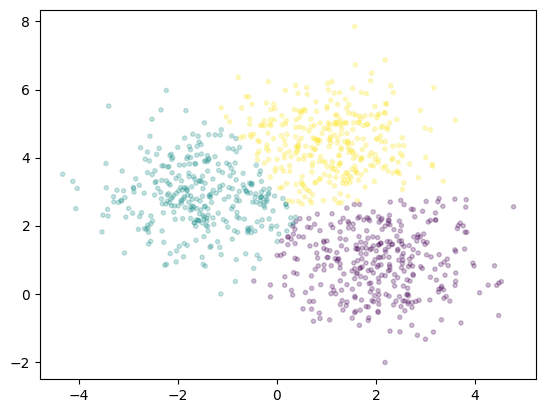

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);

### Perform hyperparameter search with Dask ML

Create a dataset

In [21]:
from dask_ml.datasets import make_classification
X, y = make_classification(n_samples=100000, n_classes=2, n_redundant=0,
                          random_state=0, shuffle=False,chunks=50)
X = X.persist()
X

dask.array<normal, shape=(100000, 20), dtype=float64, chunksize=(50, 20), chunktype=numpy.ndarray>

In [22]:
from dask_ml.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform
from sklearn.linear_model import SGDClassifier


model = SGDClassifier(eta0=0.01)
params = {
    "l1_ratio": uniform(0, 1),
    "alpha": loguniform(1e-5, 1e-1),
    "penalty": ["l2", "l1", "elasticnet"],
    "learning_rate": ["invscaling", "adaptive"],
    "power_t": uniform(0, 1),
    "average": [True, False],
}
search = RandomizedSearchCV(model, params, cv=2)
search.fit(X, y)

RandomizedSearchCV(cv=2, estimator=SGDClassifier(eta0=0.01),
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7face4349690>,
                                        'average': [True, False],
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7face42ffeb0>,
                                        'learning_rate': ['invscaling',
                                                          'adaptive'],
                                        'penalty': ['l2', 'l1', 'elasticnet'],
                                        'power_t': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fade8178850>})

In [23]:
search.score(X, y)

0.64801

In [24]:
search.best_estimator_

SGDClassifier(alpha=0.0001537539473268075, eta0=0.01,
              l1_ratio=0.7366456937921603, learning_rate='invscaling',
              penalty='elasticnet', power_t=0.32485517042187784)